In [1]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

C:\Users\dcdmm\anaconda3\envs\pytorch_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [3]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [4]:
# label.shape = (num_sample, 1)
train_dataset = xgb.DMatrix(data=X_train, label=y_train_enc)
val_dataset = xgb.DMatrix(data=X_va, label=y_va_enc)
test_dataset = xgb.DMatrix(data=X_test)

In [5]:
params = {'objective': 'multi:softprob',
          "eval_metric": 'mlogloss',
           "verbosity": 0,
          'num_class': 7}

# train_dataset的名称为train_,val_dataset的名称定义为val_
eval_set = [(train_dataset, "train_"), (val_dataset, "val_")]
evals_result = {}  # 储存评估指标(内置和自定义)结果

In [6]:
from sklearn.metrics import log_loss


def my_xgb_loss(y_pred, y_true):
    """xgboost自定义验证数据集损失函数格式"""
    loss = log_loss(y_true.get_label(), y_pred)
    return 'MY_GBM_LOSS', loss

In [7]:
model = xgb.train(params=params,
                  dtrain=train_dataset,
                  # num_boost_round (int) – Number of boosting iterations.
                  # 默认num_boost_round=10
                  num_boost_round=200,
                  # List of validation sets for which metrics will evaluated during training.
                  evals=eval_set,
                  early_stopping_rounds=100,
                  # verbose_eval (bool or int) – Requires at least one item in evals.
                  # If verbose_eval is True then the evaluation metric on the validation set is printed at each boosting stage.
                  # If verbose_eval is an integer then the evaluation metric on the validation set is printed at every given verbose_eval boosting stage.
                  # The last boosting stage / the boosting stage found by using
                  verbose_eval=20,  # 默认verbose_eval=True
                  evals_result=evals_result,
                  feval=my_xgb_loss,
                  )

[0]	train_-mlogloss:1.34273	train_-MY_GBM_LOSS:1.24385	val_-mlogloss:1.42568	val_-MY_GBM_LOSS:1.34115
[20]	train_-mlogloss:0.16260	train_-MY_GBM_LOSS:0.39326	val_-mlogloss:0.47218	val_-MY_GBM_LOSS:1.30729
[40]	train_-mlogloss:0.07440	train_-MY_GBM_LOSS:0.30875	val_-mlogloss:0.43911	val_-MY_GBM_LOSS:1.59660
[60]	train_-mlogloss:0.03785	train_-MY_GBM_LOSS:0.24241	val_-mlogloss:0.44201	val_-MY_GBM_LOSS:1.65919
[80]	train_-mlogloss:0.02267	train_-MY_GBM_LOSS:0.20066	val_-mlogloss:0.45400	val_-MY_GBM_LOSS:1.69243
[100]	train_-mlogloss:0.01526	train_-MY_GBM_LOSS:0.16981	val_-mlogloss:0.47282	val_-MY_GBM_LOSS:1.82420
[101]	train_-mlogloss:0.01512	train_-MY_GBM_LOSS:0.16944	val_-mlogloss:0.47418	val_-MY_GBM_LOSS:1.82706


In [8]:
# 预测结果为概率向量(多分类)
# test_dataset:The dmatrix storing the input
model.predict(test_dataset)

array([[9.02920403e-03, 4.93891835e-01, 1.48555599e-04, ...,
        4.96122509e-01, 5.82668581e-04, 1.61810618e-04],
       [2.77529028e-03, 9.96916413e-01, 5.80312808e-05, ...,
        6.90345478e-05, 2.93965950e-05, 1.09681714e-04],
       [4.95212572e-03, 8.59856069e-01, 2.61545065e-04, ...,
        1.29187435e-01, 4.55217296e-03, 6.25305693e-04],
       ...,
       [9.65610903e-04, 5.32144331e-05, 8.08356845e-07, ...,
        7.70229519e-07, 4.52739755e-07, 9.98978138e-01],
       [6.71224494e-04, 7.74845073e-04, 4.94533079e-03, ...,
        7.35663052e-04, 9.68498707e-01, 1.79651513e-04],
       [4.62112257e-05, 9.98612046e-01, 3.35763834e-05, ...,
        1.26232102e-03, 1.67943981e-05, 1.63618715e-05]], dtype=float32)

In [9]:
evals_result

{'train_': OrderedDict([('mlogloss',
               [1.342732,
                1.048148,
                0.851831,
                0.711859,
                0.608305,
                0.533578,
                0.468146,
                0.412388,
                0.37032,
                0.334657,
                0.30709,
                0.279878,
                0.258922,
                0.243167,
                0.227561,
                0.216905,
                0.205262,
                0.19526,
                0.183744,
                0.172979,
                0.162599,
                0.152537,
                0.145805,
                0.138035,
                0.132519,
                0.127639,
                0.121952,
                0.11504,
                0.110147,
                0.104219,
                0.100448,
                0.09733,
                0.095224,
                0.091647,
                0.088495,
                0.086438,
                0.083785,
      

In [10]:
evals_result['train_'].keys()

odict_keys(['mlogloss', 'MY_GBM_LOSS'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

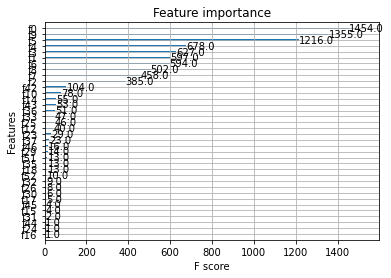

In [11]:
# 绘制特征的相对重要性
xgb.plot_importance(model)

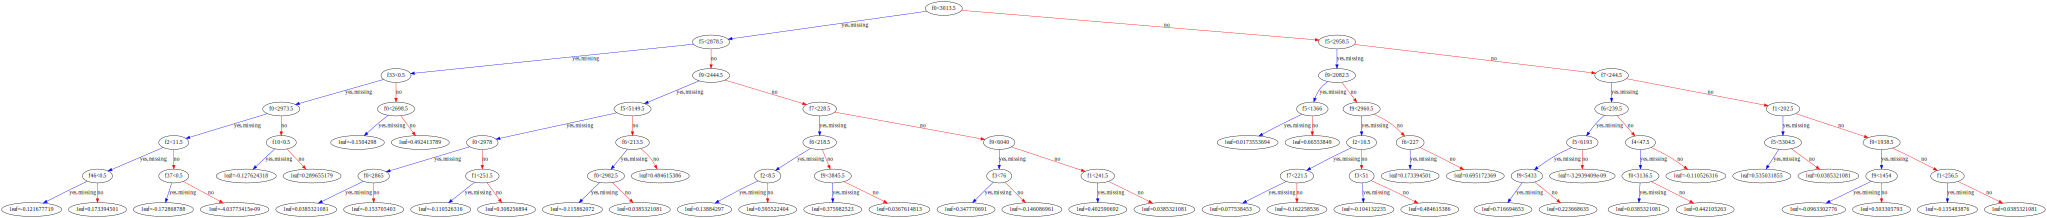

In [12]:
# 可视化lgb分割过程
img = xgb.to_graphviz(model)
img

In [13]:
# 数据类型graphviz.files.Source
type(img)

graphviz.sources.Source